# Ciência de Dados na Saúde: Criando Modelos para Predição do Câncer

## # Case: Classificação de Câncer por meio de microRNA

**Descrição dos Dados:** Os dados foram coletados do [The Cancer Genome Atlas](https://www.cancer.gov/ccg/research/genome-sequencing/tcga) (TCGA), que é um programa internacional e de referência mundial de caracterização de mais de 33 tipos de câncer. Os dados são reais e foram devidamente anonimizados. Cada linha representa a amostra retirada de uma pessoa. As colunas são os tipos de microRNA e cada entrada representa a intensidade com que aquele microRNA está expresso. Os valores de expressão variam entre $[0, \infty]$. Valores próximos a zero indicam pouca expressão enquanto que o contrário indica uma alta expressão. Os dados também apresentam rótulos (veja o atributo class) sendo TP (primary solid tumor) indicando tumor e NT (normal tissue).


**Objetivo:** Construir um modelo para predizer quando uma pessoa tem câncer dado um exame de sequenciamento do RNA.

## Leitura dos Dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

In [2]:
# Importando o arquivo e o atribuindo a um objeto df
df = pd.read_csv("brca_mirnaseq.csv", decimal=",", sep=";", header=0)
df.head()

,hsa.let.7a.1,hsa.let.7a.2,hsa.let.7a.3,hsa.let.7b,hsa.let.7c,hsa.let.7d,hsa.let.7e,hsa.let.7f.1,hsa.let.7f.2,hsa.let.7g,...,hsa.mir.941.1,hsa.mir.942,hsa.mir.943,hsa.mir.944,hsa.mir.95,hsa.mir.96,hsa.mir.98,hsa.mir.99a,hsa.mir.99b,class
0,8962.996542,17779.575039,9075.200383,24749.898857,341.298400,406.164781,1470.179650,14.716795,3627.642977,387.417272,...,0.0,5.530515,0.187475,2.062226,4.124452,119.984057,53.992826,130.201449,46548.939810,TP
1,7739.739862,15524.941906,7713.626636,23374.640471,801.487258,513.297924,560.962427,20.922042,6557.093894,350.955461,...,0.0,8.180047,0.000000,0.629234,1.258469,60.249189,86.047798,236.434808,12644.149725,TP
2,8260.612670,16497.981335,8355.342958,10957.355911,635.811272,620.351816,2694.331127,39.799878,11830.760394,600.725980,...,0.0,3.618171,0.000000,0.767491,1.644623,97.252043,117.645369,191.434123,33083.456616,TP
3,9056.241254,18075.168478,9097.666150,26017.522731,2919.348415,334.245155,1322.434475,17.866463,6438.725384,354.957604,...,0.0,3.478426,0.000000,3.478426,1.739213,72.572624,41.583007,1046.690127,24067.232290,TP
4,10897.303665,21822.338727,10963.956320,22204.253575,3313.009950,350.615669,1711.886682,22.541895,8246.117280,333.425447,...,0.0,2.108235,0.000000,1.135203,0.810860,19.947145,34.380445,1081.037952,25715.275426,TP


In [3]:
#Verificando quantidade de indivíduos e features (892 indivíduos, 898 features)
df.shape

(842, 898)

## Análise Exploratória dos Dados

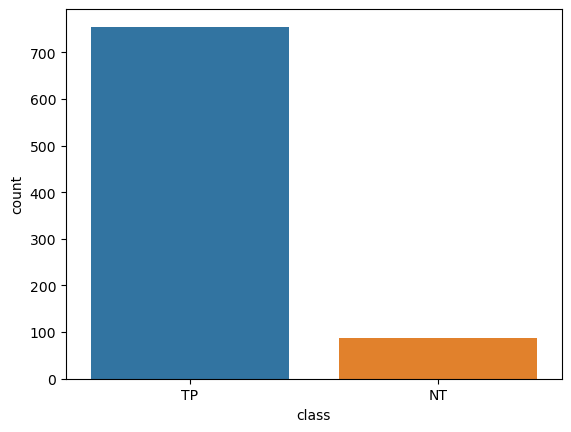

In [4]:
# Checando balanceamento entre os dados
ax = sns.countplot(x="class", data=df, hue="class")

In [5]:
# Checando a quantidade exata de cada classe 
df["class"].value_counts()

class
TP    755
NT     87
Name: count, dtype: int64

In [6]:
# Checando a proporção entre as classes
df["class"].value_counts(normalize=True)*100

class
TP    89.667458
NT    10.332542
Name: proportion, dtype: float64

In [7]:
# Explorando a distribuição geral dos dados
df.describe()

,hsa.let.7a.1,hsa.let.7a.2,hsa.let.7a.3,hsa.let.7b,hsa.let.7c,hsa.let.7d,hsa.let.7e,hsa.let.7f.1,hsa.let.7f.2,hsa.let.7g,...,hsa.mir.940,hsa.mir.941.1,hsa.mir.942,hsa.mir.943,hsa.mir.944,hsa.mir.95,hsa.mir.96,hsa.mir.98,hsa.mir.99a,hsa.mir.99b
count,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,...,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000
mean,9218.938921,18432.504585,9289.250466,26606.604836,3152.699471,558.321269,1289.570177,24.359962,8687.461926,610.223836,...,5.902975,0.003737,6.446279,0.061018,2.320737,3.150482,38.307053,63.746405,1034.572148,44369.112203
std,4843.796136,9704.187427,4858.691217,16745.347957,3238.003201,346.883205,763.056055,12.490091,6052.615278,317.854963,...,8.325681,0.049274,9.541682,0.172214,6.527536,4.287594,33.791795,40.145314,1117.491608,32754.290751
min,1294.149164,2599.981125,1319.952907,1817.920354,148.795934,79.783216,161.181457,2.439034,653.474578,88.614573,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.374223,18.400719,3475.079227
25%,5902.143848,11741.467528,5933.706564,14580.357100,1276.700850,330.638301,809.867504,16.441786,4648.822942,410.859815,...,1.378098,0.000000,2.464140,0.000000,0.373238,1.201951,14.906921,39.913493,387.430475,22769.094433
50%,8016.628565,16040.589880,8103.783439,23097.825936,2352.902327,481.342371,1101.403395,21.890340,7019.157941,532.277053,...,3.192098,0.000000,4.127957,0.000000,1.036215,2.235731,29.634884,52.993693,710.026124,35594.670263
75%,11236.887034,22538.594950,11289.595988,34373.185504,3971.192192,681.931022,1619.864372,29.395515,10926.448322,724.277709,...,7.159431,0.000000,7.551755,0.000000,2.345941,4.030888,51.258145,75.993914,1242.434228,53462.034662
max,45101.697434,90233.655610,45095.490102,144706.427973,59677.212349,3370.036117,11617.011618,121.408006,80780.055188,3342.745045,...,91.996543,0.909391,184.185656,1.757516,122.685820,93.402785,259.127121,399.078716,15689.499524,248074.178531


## Estabelecendo um Baseline Comparativo

Antes de qualquer modelagem, vamos estabelecer um baseline, i.e., uma solução simples para o problema.

In [8]:
# Separando a feature que eu quero prever (variável dependente) em outro dataframe(y) e as features independentes no dataframe X de forma estratificada em 30%/70%
X = df.drop("class", axis=1)
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [9]:
# Verificando se a estratificação foi feita corretamente entre o y de treino
y_train.value_counts(normalize=True)*100

class
TP    89.643463
NT    10.356537
Name: proportion, dtype: float64

In [10]:
# Verificando se a estratificação foi feita corretamente entre o y de teste
y_test.value_counts(normalize=True)*100

class
TP    89.72332
NT    10.27668
Name: proportion, dtype: float64

In [11]:
lrc = LogisticRegression(random_state=42)
cv_list_lr_baseline = cross_val_score (
    lrc,
    X_train,
    y_train, 
    cv=10,
    scoring="balanced_accuracy"
)

C:\Users\renat\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\renat\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [12]:
#Verificando a acurácia balanceada (bac) e desvio-padrão
mean_cv_lr_baseline = np.mean(cv_list_lr_baseline)
std_cv_lr_baseline = np.std(cv_list_lr_baseline)
print(f"Performance (bac): {round(mean_cv_lr_baseline,4)} +- {round(std_cv_lr_baseline,4)}")

Performance (bac): 0.9201 +- 0.046


## Modelagem

In [13]:
knn = Pipeline (
    [
        ("mms", MinMaxScaler()),
        ("skb", SelectKBest(chi2, k=10)),
        ("knn", KNeighborsClassifier(n_neighbors=3, p=2,weights="uniform"))
    ]
)

cv_list_knn_euclid = cross_val_score (
    knn,
    X_train,
    y_train,
    cv=10, 
    scoring="balanced_accuracy"
)

mean_cv_list_knn_euclid = np.mean(cv_list_knn_euclid)
std_cv_list_knn_euclid = np.std(cv_list_knn_euclid)

print(f"Performance (bac): {round(mean_cv_list_knn_euclid,4)} +- {round(std_cv_list_knn_euclid,4)}")

Performance (bac): 0.9703 +- 0.0377


In [14]:
#

In [15]:
#

In [16]:
#

In [17]:
#

## Avaliação Experimental

In [18]:
# resultados da cross-validacao


In [19]:
#

In [20]:
#

In [21]:
#

## Vamos avaliar a performance final do nosso modelo

In [22]:
# retreinar o pipeline selecionado com todos os dados de treinamento


In [23]:
# Confusion matrix


In [24]:
#

## Referências & Links



1. [The Cancer Genome Atlas Program](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga)
2. [Micro RNA](https://en.wikipedia.org/wiki/MicroRNA_sequencing)
3. [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
